# Sprint 1: Formalización del problema

## Espacio de codificación de soluciones


Número de autores en el grafo: 1843
Número de aristas en el grafo: 3215


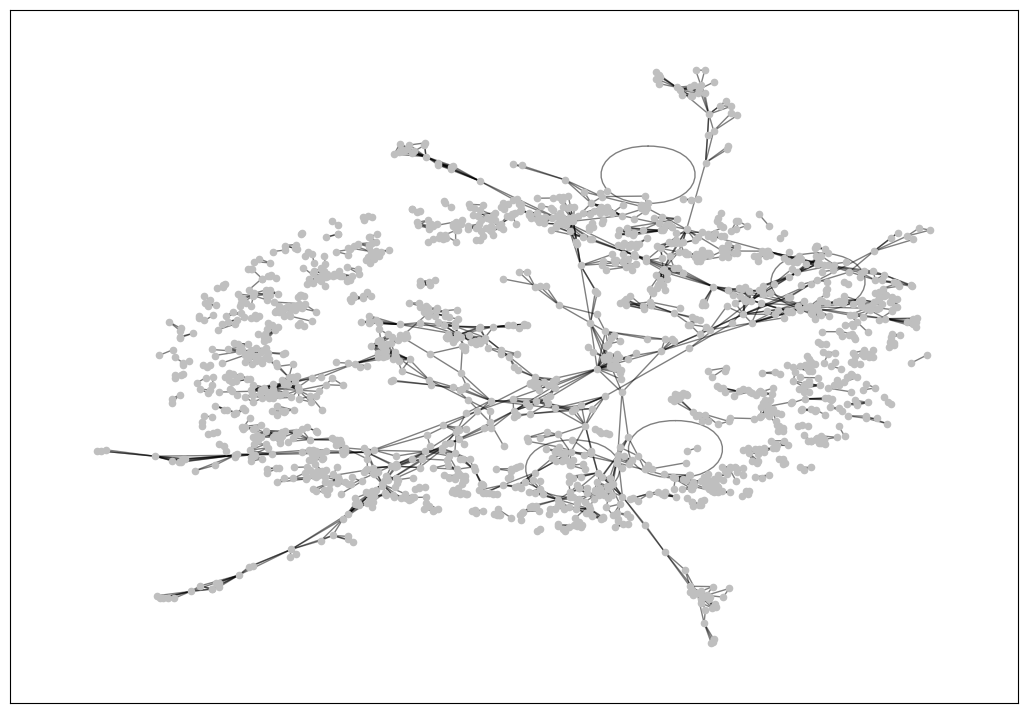

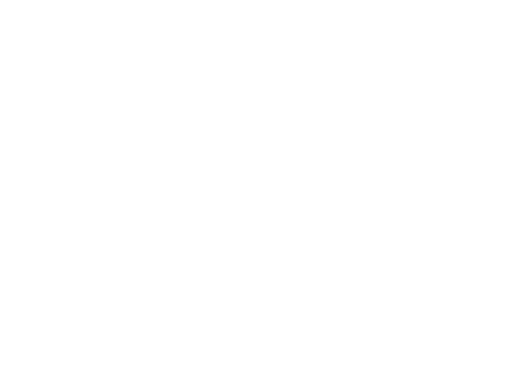

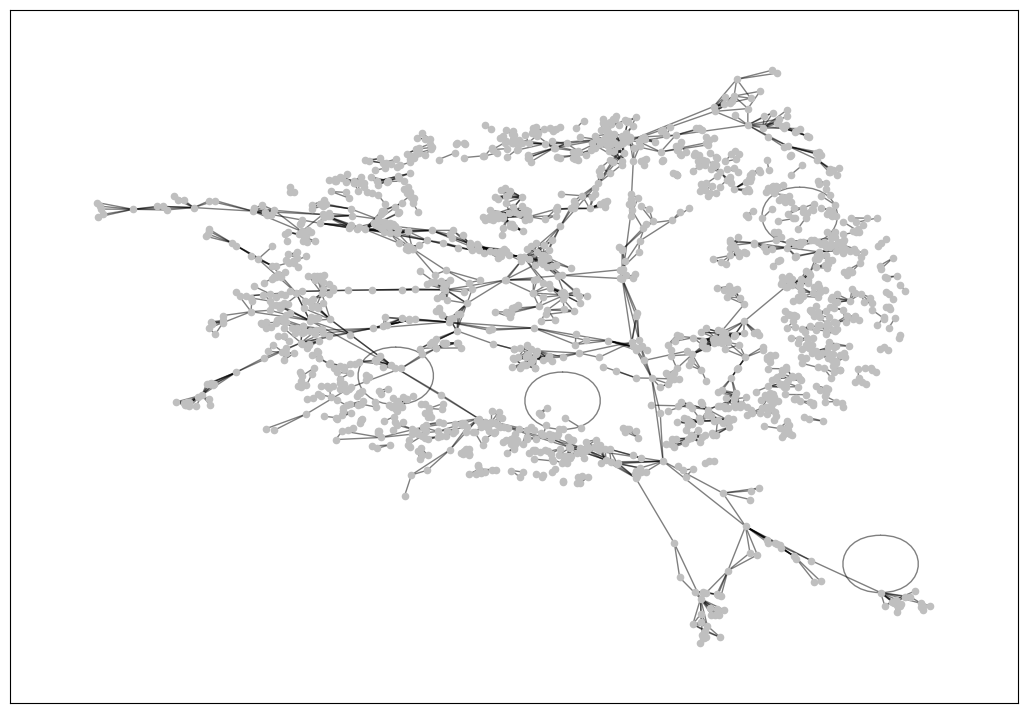

In [1]:
import import_ipynb
import CDP_0_SRC
from itertools import product
import community
import networkx as nx
import numpy as np
import random as rn
import time

In [3]:
N = 1000
k_value = 4
G = CDP_0_SRC.crear_grafo()

def generate_random_partition_with_all_nodes(G, k):
    partition = {node: np.random.randint(1, k+1) for node in G.nodes()}
    return partition

sol_1 = generate_random_partition_with_all_nodes(G, k_value)
sol_2 = generate_random_partition_with_all_nodes(G, k_value)
sol_3 = generate_random_partition_with_all_nodes(G, k_value)

print("SOLUCIÓN 1")
print("Asignación de comunidades a nodos:")
print(sol_1)

print("\nSOLUCIÓN 2")
print("Asignación de comunidades a nodos:")
print(sol_2)

print("\nSOLUCIÓN 3")
print("Asignación de comunidades a nodos:")
print(sol_3)

SOLUCIÓN 1
Asignación de comunidades a nodos:
{'Nan Li': 1, 'Rong Jin': 4, 'Zhi-Hua Zhou': 2, 'Fajwel Fogel': 3, "Alexandre d'Aspremont": 1, 'Milan Vojnovic': 3, 'Nisheeth Srivastava': 2, 'Ed Vul': 2, 'Paul R. Schrater': 4, 'Sewoong Oh': 4, 'Devavrat Shah': 2, 'Siu On Chan': 1, 'Ilias Diakonikolas': 2, 'Rocco A. Servedio': 4, 'Xiaorui Sun': 2, 'Aaron van den Oord': 4, 'Benjamin Schrauwen': 2, 'Robert A. Vandermeulen': 2, 'Clayton Scott': 3, 'Qiang Liu': 3, 'Alexander T. Ihler': 1, 'Joseph G. Makin': 3, 'Philip N. Sabes': 1, 'Isabel Valera': 4, 'Zoubin Ghahramani': 3, 'Kumar Dubey': 1, 'Qirong Ho': 1, 'Sinead A. Williamson': 4, 'Eric P. Xing': 1, 'Anqi Wu': 3, 'Mijung Park': 2, 'Oluwasanmi O. Koyejo': 1, 'Jonathan W. Pillow': 4, 'Balaji Lakshminarayanan': 3, 'Daniel M. Roy': 2, 'Yee Whye Teh': 4, 'Jason Chang': 2, 'John W. Fisher III': 4, 'Mehmet G?nen': 2, 'Adam A. Margolin': 1, 'Qichao Que': 4, 'Mikhail Belkin': 2, 'Yusu Wang': 3, 'Bo Dai': 1, 'Bo Xie': 1, 'Niao He': 3, 'Yingyu Liang'

### Función objetivo


In [4]:
# Función objetivo
def modularidad(G, particion, weight='weight'):
    """
    #Cálculo manual de la modularidad de una partición dada.
    """
    
    m = G.size(weight=weight)
    if m == 0:
        return 0
    
    grados = dict(G.degree(weight=weight))

    Q = 0.0
    for u, v, data in G.edges(data=True):
        w = data.get(weight, 1.0)
        if particion[u] == particion[v]:
            Q += w - (grados[u] * grados[v]) / (2 * m)
    
    fitness = Q / (2 * m)
    return fitness 

## Nuestra implementación
partition1 = sol_1
partition2 = sol_2
partition3 = sol_3

print("Fitness solucion 1: {} ".format(modularidad(G, partition1)))
print("Fitness solucion 2: {} ".format(modularidad(G, partition2)))
print("Fitness solucion 3: {} ".format(modularidad(G, partition3)))

Fitness solucion 1: 0.12385620338143052 
Fitness solucion 2: 0.12197752632313615 
Fitness solucion 3: 0.12625704846124586 


### Función de vecindad

In [5]:
# Función de vecindad
def random_move_operator(partition, k):
    new_partition = partition.copy()

    u = rn.choice(list(partition.keys()))
    current_community = partition[u]

    possible_communities = [c for c in range(1, k+1) if c != current_community]
    if not possible_communities:
        return new_partition

    new_partition[u] = rn.choice(possible_communities)
    return new_partition

def get_unique_neighbors(partition, k, num_vecinos):
    """
    Genera una lista de 'num_vecinos' particiones ÚNICAS.
    Evita devolver candidatos repetidos.
    """
    neighbors = []
    nodes = list(partition.keys())
    
    # Usamos un set para guardar los movimientos (nodo, nueva_comunidad)
    # Esto evita automáticamente duplicados
    moves_set = set()
    
    # Calculamos el límite teórico de movimientos posibles: N * (k-1)
    # Si num_vecinos es mayor que esto, lo limitamos para evitar bucles infinitos
    max_possible_moves = len(nodes) * (k - 1)
    target_count = min(num_vecinos, max_possible_moves)
    
    while len(moves_set) < target_count:
        # 1. Elegir nodo al azar
        u = rn.choice(nodes)
        current_comm = partition[u]
        
        # 2. Elegir una comunidad destino diferente a la actual
        possible_communities = [c for c in range(1, k+1) if c != current_comm]
        
        if possible_communities:
            new_comm = rn.choice(possible_communities)
            
            # 3. Intentar añadir al set. Si ya existe, el set lo ignora y el bucle sigue.
            moves_set.add((u, new_comm))

    # Una vez tenemos los movimientos únicos, creamos las particiones
    for u, new_comm in moves_set:
        new_partition = partition.copy()
        new_partition[u] = new_comm
        neighbors.append(new_partition)
        
    return neighbors

# Aplicar operador move
new_partition1 = random_move_operator(partition1, k_value)
new_partition2 = random_move_operator(partition2, k_value)
new_partition3 = random_move_operator(partition3, k_value)

print("Fitness solucion 1: {} ".format(modularidad(G, new_partition1)))
print("Fitness solucion 2: {} ".format(modularidad(G, new_partition2)))
print("Fitness solucion 3: {} ".format(modularidad(G, new_partition3)))

Fitness solucion 1: 0.12385620338143052 
Fitness solucion 2: 0.12183501656259667 
Fitness solucion 3: 0.1263999055574024 


### Criterio de selección

In [6]:
def hill_climbing_steepest(G, initial_partition, k, max_iters, num_vecinos):
    """
    Hill Climbing Steepest Ascent con garantía de vecinos únicos.
    """
    current_partition = initial_partition.copy()
    current_fitness = modularidad(G, current_partition)
    
    print(f"INICIO -> Fitness inicial: {current_fitness:.6f}")
    
    for i in range(max_iters):
        
        # A. Generar lista de vecinos ÚNICOS
        candidates = get_unique_neighbors(current_partition, k, num_vecinos)
        
        # B. Encontrar el mejor de ese grupo
        best_neighbor = None
        best_neighbor_fitness = -1.0
        
        for candidate in candidates:
            fit = modularidad(G, candidate)
            if fit > best_neighbor_fitness:
                best_neighbor_fitness = fit
                best_neighbor = candidate
        
        # C. Comparar con el actual
        if best_neighbor_fitness > current_fitness:
            print(f"   [Iter {i+1}] Mejora (de {len(candidates)} vecinos únicos): {current_fitness:.6f} -> {best_neighbor_fitness:.6f}")
            current_partition = best_neighbor
            current_fitness = best_neighbor_fitness
        else:
            # Si no mejora, seguimos buscando en la siguiente iteración con otros vecinos aleatorios
            pass

    print(f"FIN -> Mejor Fitness final: {current_fitness:.6f}")
    return current_partition, current_fitness


# --- HIPERPARÁMETROS ---
ITERACIONES = 100      # x iteraciones
VECINOS_POR_PASO = 20 # x cantidad de vecinos únicos a evaluar

print(f"--- Ejecurando HC Steepest (Iter: {ITERACIONES}, Vecinos Únicos: {VECINOS_POR_PASO}) ---\n")

print("OPTIMIZANDO SOLUCIÓN 1:")

# 1. Registrar el tiempo de inicio
start_time = time.time() 

# 2. Ejecutar la función
best_sol_1, best_fit_1 = hill_climbing_steepest(G, sol_1, k_value, ITERACIONES, VECINOS_POR_PASO)

# 3. Registrar el tiempo de finalización
end_time = time.time() 

# 4. Calcular la duración
elapsed_time = end_time - start_time

print("\n--- RESULTADO DE LA OPTIMIZACIÓN ---")
print(f"Mejor Modularidad Final: {best_fit_1:.6f}")
print(f"Tiempo de Ejecución Total: {elapsed_time:.4f} segundos")

--- Ejecurando HC Steepest (Iter: 100, Vecinos Únicos: 20) ---

OPTIMIZANDO SOLUCIÓN 1:
INICIO -> Fitness inicial: 0.123856
   [Iter 1] Mejora (de 20 vecinos únicos): 0.123856 -> 0.124142
   [Iter 2] Mejora (de 20 vecinos únicos): 0.124142 -> 0.124427
   [Iter 3] Mejora (de 20 vecinos únicos): 0.124427 -> 0.124572
   [Iter 4] Mejora (de 20 vecinos únicos): 0.124572 -> 0.124856
   [Iter 5] Mejora (de 20 vecinos únicos): 0.124856 -> 0.125427
   [Iter 6] Mejora (de 20 vecinos únicos): 0.125427 -> 0.125712
   [Iter 7] Mejora (de 20 vecinos únicos): 0.125712 -> 0.126140
   [Iter 8] Mejora (de 20 vecinos únicos): 0.126140 -> 0.126710
   [Iter 9] Mejora (de 20 vecinos únicos): 0.126710 -> 0.127138
   [Iter 10] Mejora (de 20 vecinos únicos): 0.127138 -> 0.127423
   [Iter 11] Mejora (de 20 vecinos únicos): 0.127423 -> 0.128132
   [Iter 12] Mejora (de 20 vecinos únicos): 0.128132 -> 0.128699
   [Iter 13] Mejora (de 20 vecinos únicos): 0.128699 -> 0.128985
   [Iter 14] Mejora (de 20 vecinos único